In [1]:
import os
import numpy as np
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

In [2]:
with zipfile.ZipFile('archive.zip','r') as f:
    f.extractall('archive')

In [2]:
crops = ['jute','maize','rice','sugarcane','wheat']
path = 'archive/kag2'
test_path = 'archive_test/test_crop_image'

In [3]:
img_height = 256 
img_width = 256
batch_size = 16
num_classes = 5

def load_data(path,dataset):
    data = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split = 0.2,
        subset = dataset,
        batch_size=batch_size, 
        image_size=(img_height,img_width),
        shuffle=True, seed=0
    )
    return data


In [4]:
train = load_data(path,'training')

Found 854 files belonging to 5 classes.
Using 684 files for training.


In [5]:
dev = load_data(path,'validation')

Found 854 files belonging to 5 classes.
Using 170 files for validation.


In [6]:
class_names = train.class_names
class_names

['jute', 'maize', 'rice', 'sugarcane', 'wheat']

In [7]:
label_class = {}
for i,label in enumerate(class_names):
    label_class[label] = i

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dev = dev.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
initial_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu',
               kernel_regularizer = tf.keras.regularizers.L2(0.1),
               activity_regularizer = tf.keras.regularizers.L2(0.01)),
  layers.Dense(num_classes,
               kernel_regularizer = tf.keras.regularizers.L2(0.1),
               activity_regularizer = tf.keras.regularizers.L2(0.01)),
  
])

In [10]:
def compile_model(model,opt):
    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    return 

In [11]:
def train_model(model,epochs):
    history = model.fit(
            train,
            validation_data = dev,
            epochs = epochs
        )
    model.summary()
    return history

In [12]:
def plot_curves(history,epochs):
    acc = history.history['accuracy']
    dev_acc = history.history['val_accuracy']
    loss = history.history['loss']
    dev_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, dev_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, dev_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
def load_test_data():
    with zipfile.ZipFile('archive_test.zip','r') as f_t:
        f_t.extractall('archive_test')
    test_data = pd.read_csv('archive_test/testdata.csv').iloc[:,1:]
    path_kaggle = '/kaggle/input/testssss/test_crop_image/'
    path_test_data = []
    for i in test_data['testpath']:
        path_test_data.append(os.path.relpath(i,path_kaggle))
    test_data['image'] = path_test_data
    return path_test_data,test_data

In [14]:
def test_model(image_path,model):
    img = tf.keras.preprocessing.image.load_img(
            image_path,
            target_size = (img_height,img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_tensor = tf.expand_dims(img_array, 0)
    pred = model.predict(img_tensor)
    score = tf.nn.softmax(pred)
    class_name = class_names[np.argmax(score)]
    confidence = 100*np.max(score)
    pred_label = label_class[class_name]
    return class_name,confidence,pred_label

In [15]:
def acc_score(path_test_data,test_data,model):  
    test_list = []
    for test_file in path_test_data:
        class_name,percentage,label = test_model(os.path.join(test_path,test_file),model)
        test_list.append(label)
    test_data['pred'] = test_list
    y_true = test_data['croplabel']
    y_pred = test_data['pred']    
    acc = accuracy_score(y_true,y_pred)
    return acc*100

In [16]:
def pipeline(epochs,model,opt):
    compile_model(model,opt)
    history = train_model(model,epochs)
    plot_curves(history,epochs)
    path_test_data,test_data = load_test_data()
    acc = acc_score(path_test_data,test_data,model)
    return print('Accuracy score in the test set: ',acc)

### Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

In [19]:
opt_2 = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
opt_3 = tf.keras.optimizers.SGD(learning_rate = 0.01,name  = 'SGD')

In [20]:
model_ag_data = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,kernel_regularizer = tf.keras.regularizers.L2(0.01))    
])


Epoch 1/100
43/43 [==============================] - 6s 73ms/step - loss: 1.7214 - accuracy: 0.2190 - val_loss: 1.7126 - val_accuracy: 0.1941
Epoch 2/100
43/43 [==============================] - 2s 46ms/step - loss: 1.6875 - accuracy: 0.2390 - val_loss: 1.6478 - val_accuracy: 0.3647
Epoch 3/100
43/43 [==============================] - 2s 47ms/step - loss: 1.6379 - accuracy: 0.2959 - val_loss: 1.5651 - val_accuracy: 0.4176
Epoch 4/100
43/43 [==============================] - 2s 47ms/step - loss: 1.5755 - accuracy: 0.3564 - val_loss: 1.5591 - val_accuracy: 0.3353
Epoch 5/100
43/43 [==============================] - 2s 47ms/step - loss: 1.5441 - accuracy: 0.3525 - val_loss: 1.4183 - val_accuracy: 0.4706
Epoch 6/100
43/43 [==============================] - 2s 47ms/step - loss: 1.5137 - accuracy: 0.3950 - val_loss: 1.4924 - val_accuracy: 0.3824
Epoch 7/100
43/43 [==============================] - 2s 47ms/step - loss: 1.4142 - accuracy: 0.4126 - val_loss: 1.3635 - val_accuracy: 0.4882
Epoch 

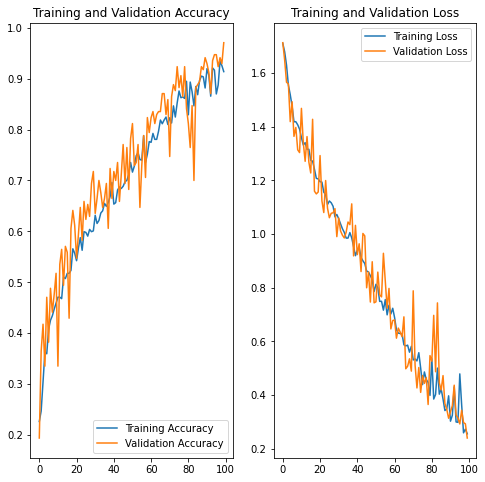

Accuracy score in the test set:  66.66666666666666


In [21]:
pipeline(100,model_ag_data,opt_3)